In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import cifar10
import random



In [ ]:
def image_generator():

    generator = Sequential()

    generator.add(Dense(256*4*4, input_shape = (100,)))
    generator.add(LeakyReLU())
    generator.add(Reshape((4,4,256)))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generator.add(LeakyReLU(alpha=0.2))


    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generator)

model_generator = image_generator()

model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         295040    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       147584    
 Transpose)                                             

1/1 [==============================] - 2s 2s/step


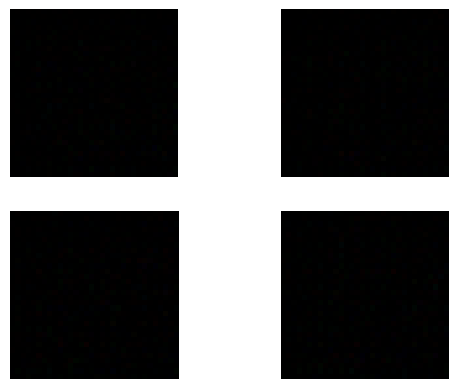

In [ ]:
def generate_input_data(n_samples):
  X = np.random.randn(100 * n_samples)
  X = X.reshape(n_samples, 100)
  return X

def create_fake_data(model_generator, n_samples):
  input = generate_input_data(n_samples)
  X = model_generator.predict(input)
  y = np.zeros((n_samples, 1))
  return X,y

sample_number = 4
X,_ = create_fake_data(model_generator, sample_number)

for i in range(sample_number):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [ ]:
def image_discriminator():

    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminator)

model_discriminator = image_discriminator()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
def get_images():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()


    index = np.where(Ytrain == 0)
    index = index[0]
    Xtrain = Xtrain[index, :,:,:]


    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(get_images().shape)

170498071/170498071 [==============================] - 6s 0us/step
(5000, 32, 32, 3)


In [ ]:
def load_real_data(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

def load_fake_data(n_samples):
  X = np.random.rand(32 * 32 * 3 * n_samples)
  X = -1 + X * 2
  X = X.reshape((n_samples, 32,32,3))
  y = np.zeros((n_samples, 1))
  return X,y

In [ ]:
def train_discriminator(model, dataset, n_iterations=20, batch = 128):
  medium_batch = int(batch/2)

  for i in range(n_iterations):
    X_real, y_real = load_real_data(dataset, medium_batch)
    _, acc_real = model.train_on_batch(X_real, y_real)

    X_fake, y_fake = load_fake_data(medium_batch)
    _, acc_fake = model.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [ ]:
dataset = get_images()
train_discriminator(model_discriminator, dataset)

1 Real:54.6875, Fake:0.0
2 Real:98.4375, Fake:1.5625
3 Real:93.75, Fake:79.6875
4 Real:89.0625, Fake:100.0
5 Real:92.1875, Fake:100.0
6 Real:93.75, Fake:100.0
7 Real:98.4375, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:98.4375, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


In [ ]:
def create_win(discriminator, generador):
    discriminator.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminator)

    opt = Adam(lr=0.0002,beta_1=0.5)
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = create_win(model_discriminator,model_generator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1007363   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1529860 (5.84 MB)
Trainable params: 1007363 (3.84 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [ ]:
def show_generated_images(data_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  data_fake = (data_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(data_fake[i])
    plt.axis('off')
    number = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(number, bbox_inches='tight')
    plt.close()

In [ ]:
def evaluate_and_save(model_generator, epoch, medium_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  number = str(epoch) + '_' + str(now)+"_model_generator_" + '.h5'
  model_generator.save(number)

  # We generate new data
  X_real,Y_real = load_real_data(dataset, medium_dataset)
  X_fake, Y_fake =  create_fake_data(model_generator,medium_dataset)

  # We evaluate the model
  _, acc_real = model_discriminator.evaluate(X_real, Y_real)
  _, acc_fake = model_discriminator.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
def training(datos, model_generator, model_discriminator, epochs, n_batch, start = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medium_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(start, start + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = load_real_data(dataset, medium_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      discriminator_cost_real, _ = model_discriminator.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  create_fake_data(model_generator,medium_dataset)

      discriminator_cost_fake, _ = model_discriminator.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generate_input_data(medium_dataset)
      Y_gan = np.ones((medium_dataset, 1))

      # We train the GAN with fake data
      cost_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost
    if (epoch+1) % 10 == 0:
      evaluate_and_save(model_generator,epoch = epoch, medium_dataset= medium_dataset)
      show_generated_images(X_fake, epoch = epoch)

In [ ]:
training(dataset, model_generator, model_discriminator, epochs = 10, n_batch=128, start = 0)

2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 0.5885 - accuracy: 0.7344
Acc Real:70.3125% Acc Fake:73.4375%


2/2 [==============================] - 0s 7ms/step


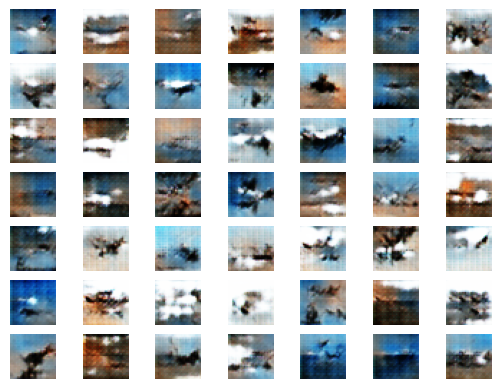

In [ ]:
X_fake, _ = create_fake_data(n_samples=49, model_generator=model_generator)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])